# Nuclear Gradients of AO Integrals in PySCF

Let's begin by importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import scf, gto

np.set_printoptions(precision=6, linewidth=200, threshold=2000, suppress=True)

Let's Setup the Water Molecule with PySCF

In [2]:
h2o = gto.Mole()
h2o.verbose = 0
h2o.atom = [
    ['O' , (0. , 0.     , 0.)],
    [1   , (0. , -0.757 , 0.587)],
    [1   , (0. , 0.757  , 0.587)] ]
h2o.basis = {'H': 'sto-3g',
             'O': 'sto-3g',}
h2o.build()
H20_HF = scf.RHF(h2o)
H20_HF.conv_tol = 1e-14
e0 = H20_HF.scf()
print(e0)

-74.96306312972916


Let's Import, prebuilt functions:

In [40]:
def h_deriv(atom_id, h1, mol):
    shl0, shl1, p0, p1 = (mol.aoslice_by_atom())[atom_id]
    with mol.with_rinv_at_nucleus(atom_id):
        vrinv  = (-mol.atom_charge(atom_id)) * mol.intor('int1e_iprinv', comp=3) # <\nabla|1/r|>
        vrinv += mol.intor('ECPscalar_iprinv', comp=3)
    vrinv[:,p0:p1] += h1[:,p0:p1]
    return vrinv + vrinv.swapaxes(1,2) 
def S_deriv(atom_id, S_xAB, mol):
    shl0, shl1, p0, p1 = (mol.aoslice_by_atom())[atom_id]

    vrinv = np.zeros(S_xAB.shape)
    vrinv[:, p0:p1, :] += S_xAB[:, p0:p1, :]
    
    return vrinv + vrinv.swapaxes(1,2)
def I_deriv(atom_id, I_xABCD, mol):
    shl0, shl1, p0, p1 = (mol.aoslice_by_atom())[atom_id]

    vrinv  = np.zeros(I_xABCD.shape)
    vrinv[:, p0:p1, :, :, :] += I_xABCD[:, p0:p1, :, :, :]
    
    vrinv += np.einsum("xABCD -> xCDAB", vrinv) 
    vrinv += np.einsum("xABCD -> xBACD", vrinv) 
    vrinv += np.einsum("xABCD -> xABDC", vrinv)
    vrinv += np.einsum("xABCD -> xBADC", vrinv)
    
    return vrinv/4.

In [41]:
h_xAB    = -h2o.intor('ECPscalar_ipnuc', comp=3)
h_xAB   += -h2o.intor('int1e_ipkin', comp=3)
h_xAB   += -h2o.intor('int1e_ipnuc', comp=3)
S_xAB    = -h2o.intor('int1e_ipovlp', comp=3)
I_xABCD  = -h2o.intor('int2e_ip1', comp=3)
dI_pyscf = np.zeros(((len(h2o.aoslice_by_atom()),) + I_xABCD.shape))
dH_pyscf = np.zeros(((len(h2o.aoslice_by_atom()),) + h_xAB.shape))
dS_pyscf = np.zeros(((len(h2o.aoslice_by_atom()),) + S_xAB.shape))
for i in range(len(h2o.aoslice_by_atom())):
    dI_pyscf[i] = I_deriv(i, I_xABCD, h2o)
    dS_pyscf[i] = S_deriv(i, S_xAB, h2o)
    dH_pyscf[i] = h_deriv(i, h_xAB, h2o)

In [42]:
print(dH_pyscf[1,1])

[[-0.24116  -0.065831 -0.044186  0.        0.010817 -0.01799   0.        0.00143  -0.002378 -1.787147 -0.014103]
 [-0.065831 -0.239444 -0.181672  0.        0.070332 -0.120916  0.        0.028594 -0.057821 -2.668707 -0.074685]
 [-0.044186 -0.181672 -0.17072   0.        0.055114 -0.113178  0.       -0.001366 -0.076276 -2.265759 -0.092244]
 [ 0.        0.        0.       -0.194333  0.        0.       -0.073471  0.        0.        0.        0.      ]
 [ 0.010817  0.070332  0.055114  0.       -0.2317    0.063477  0.       -0.081086  0.03541   0.58749  -0.017999]
 [-0.01799  -0.120916 -0.113178  0.        0.063477 -0.270309  0.        0.03541  -0.123806 -1.49982  -0.068811]
 [ 0.        0.        0.       -0.073471  0.        0.       -0.069494  0.        0.        0.        0.      ]
 [ 0.00143   0.028594 -0.001366  0.       -0.081086  0.03541   0.       -0.008753  0.006851 -0.426321 -0.039429]
 [-0.002378 -0.057821 -0.076276  0.        0.03541  -0.123806  0.        0.006851 -0.116643 -0.9

In [43]:
print(dI_pyscf[1,1,1,1])

[[ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.072644  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.243566  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.211941  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.       -0.062377  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.146954  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.036889  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.0

In [44]:
print(dS_pyscf[1,1])

[[ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.057311  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.259096  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.250574  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.       -0.058112  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.178916  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.146983  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.1

Let's try something with an ECP potential!

In [45]:
h2o = gto.Mole()
h2o.verbose = 0
h2o.atom = [
    ['O' , (0. , 0.     , 0.)],
    [1   , (0. , -0.757 , 0.587)],
    [1   , (0. , 0.757  , 0.587)] ]
h2o.basis = {'H': 'sto-3g',
             'O': 'lanl2dz',}
h2o.build()
H20_HF = scf.RHF(h2o)
H20_HF.conv_tol = 1e-14
e0 = H20_HF.scf()

Now lets define a method for this: 

In [46]:
def dints(mol):
    h_xAB    = -mol.intor('ECPscalar_ipnuc', comp=3)
    h_xAB   += -mol.intor('int1e_ipkin', comp=3)
    h_xAB   += -mol.intor('int1e_ipnuc', comp=3)
    S_xAB    = -mol.intor('int1e_ipovlp', comp=3)
    I_xABCD  = -mol.intor('int2e_ip1', comp=3)
    dI_pyscf = np.zeros(((len(mol.aoslice_by_atom()),) + I_xABCD.shape))
    dH_pyscf = np.zeros(((len(mol.aoslice_by_atom()),) + h_xAB.shape))
    dS_pyscf = np.zeros(((len(mol.aoslice_by_atom()),) + S_xAB.shape))
    for i in range(len(mol.aoslice_by_atom())):
        dI_pyscf[i] = I_deriv(i, I_xABCD, mol)
        dS_pyscf[i] = S_deriv(i, S_xAB, mol)
        dH_pyscf[i] = h_deriv(i, h_xAB, mol)
    return dI_pyscf, dS_pyscf, dH_pyscf

In [47]:
def Bohr(x): ### given Ångström get Bohr
    return 1.889726125 * x 

def Ångström(x): ### given Bohr get Ångström
    return x / 1.889726125

def get_UFock(I, H, Da, Db):
    J  = np.einsum("mnrs, rs -> mn", I, Da + Db , optimize=True)
    Kα = np.einsum("mnrs, nr -> ms", I, Da , optimize=True)
    Kβ = np.einsum("mnrs, nr -> ms", I, Db , optimize=True)
    Fα = H + J - Kα
    Fβ = H + J - Kβ
    return Fα,  Fβ

def get_Euhf(H, DA, DB, FA, FB):
    Euhf  = np.einsum("pq,pq->", DA + DB, H)
    Euhf += np.einsum("pq,pq->", DA, FA)
    Euhf += np.einsum("pq,pq->", DB, FB)
    Euhf *= 0.5
    return Euhf

def get_force(dI, dS, dH, DA, DB, FA, FB):
    D = DA + DB    

    ## Hellman Feynman
    fix  = -1.0*np.einsum("mn, IXmn -> IX",  D, dH)
    fix -=  0.5*np.einsum("nm, ls, IXmnls -> IX",  D,  D, dI, optimize=True) ## dJ
    fix +=  0.5*np.einsum("nm, ls, IXmlsn -> IX", DA, DA, dI, optimize=True) ## dKα
    fix +=  0.5*np.einsum("nm, ls, IXmlsn -> IX", DB, DB, dI, optimize=True) ## dKβ

    ## Pulay
    fix += 1.0*np.einsum("ij, IXjk, kl, il -> IX", DA, dS, DA, FA, optimize=True)
    fix += 1.0*np.einsum("ij, IXjk, kl, il -> IX", DB, dS, DB, FB, optimize=True)

    return fix

def grad_nuc(mol, atmlst=None):
    '''
    Author: Qiming Sun <osirpt.sun@gmail.com>
    Derivatives of nuclear repulsion energy wrt nuclear coordinates
    '''
    gs = np.zeros((mol.natm,3))
    for j in range(mol.natm):
        q2 = mol.atom_charge(j)
        r2 = mol.atom_coord(j)
        for i in range(mol.natm):
            if i != j:
                q1 = mol.atom_charge(i)
                r1 = mol.atom_coord(i)
                r = np.sqrt(np.dot(r1-r2,r1-r2))
                gs[j] -= q1 * q2 * (r2-r1) / r**3
    if atmlst is not None:
        gs = gs[atmlst]
    return gs

In [48]:
dI, dS, dH = dints(h2o)

Let's Scan OH (with 9 electrons) with UHF and compare the Numerical and Analytical Gradient.

In [ ]:
dx       = 0.05
distance = np.arange(0.5, 2.7, dx) ## in Ångströms
force    = np.zeros(distance.shape)
energy   = np.zeros(distance.shape)
energyA  = np.zeros(distance.shape)

oh = gto.Mole()
oh.verbose = 0
oh.atom = [
    ['O' , (0. , 0.     , 0.)],
    [1   , (0. , 0. , 0.45)]]
oh.spin = 1
oh.basis = {"H": "sto-3g",
             "O": "lanl2dz",}
oh.build()
OH_UHF = scf.UHF(oh)
OH_UHF.conv_tol = 1e-12
OH_UHF.kernel()
DA, DB = oh.make_rdm1()

for i in range(len(distance)):
    
    oh = gto.Mole()
    oh.verbose = 0
    oh.atom = [
        ['O' , (0. , 0.     , 0.)],
        [1   , (0. , 0. , distance[i])]]
    oh.spin = 1
    oh.basis = {"H": "sto-3g",
                 "O": "lanl2dz",}
    oh.build()
    OH_UHF = scf.UHF(oh)
    OH_UHF.conv_tol = 1e-12
    OH_UHF.kernel((DA, DB))
    energy[i] = OH_UHF.scf()
    
    dmA, dmB = oh.make_rdm1()
    II = oh.intor("int2e")
    H  = oh.intor("int1e_kin") + oh.intor("int1e_nuc") + oh.intor("ECPscalar") ### get ECP!!!
    
    FA, FB = get_UFock(II, H, dmA, dmB)
    energyA[i] = get_Euhf(H, dmA, dmB, FA, FB) + oh.energy_nuc()
    
    dI, dS, dH = dints(oh)
    force[i] = (get_force(dI, dS, dH, dmA, dmB, FA, FB) - grad_nuc(oh))[0,2]
    
    DA = dmA
    DB = dmB

In [ ]:
energyA - energy

In [ ]:
plt.plot(distance, energy, "-")
plt.title("Potential Energy Surface")
plt.xlabel("Interatomic Distance (Å)")
plt.ylabel("Energy")
plt.show()

In [ ]:
plt.plot(distance[1:], (-np.gradient(energy, Bohr(dx)))[1:], "-")
plt.plot(distance[1:], -force[1:], linestyle="dashed")
plt.title("Energy Gradient")
plt.xlabel("Interatomic Distance (Å)")
plt.ylabel("Energy Gradient")
plt.show()

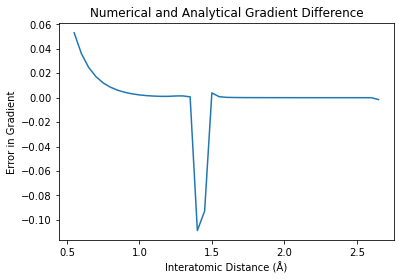

In [39]:
plt.plot(distance[1:], (-np.gradient(energy, Bohr(dx)))[1:] + (force)[1:] , "-")
plt.title("Numerical and Analytical Gradient Difference")
plt.xlabel("Interatomic Distance (Å)")
plt.ylabel("Error in Gradient")
plt.show()